In [1]:
# General import, names of train, test, val
%load_ext autoreload
%autoreload 2

import numpy as np
import pysam
from tqdm.notebook import tqdm
import h5py
import pandas as pd


basedir = '/data/leslie/shared/ASA/'
aligndir = basedir+'pseudodiploid/'
ctype = 'cd8'

datadir = basedir+'mouseASA/data/'+ctype+'/'
chrom_train = [1,2,4,6,7,8,9,11,12,13,14,16,17,18,19]
chrom_val = [3,5]
chrom_test = [10,15]
chroms = [chrom_train, chrom_val, chrom_test]
name = ['train', 'val', 'test']

# Plot test results

In [2]:
from run import load_data
modelname = 'm3'
dataset = 'both'
use_prior = '1'
batchsize = '32'
gc = ''
ident = '_vi'

predspath = f'{datadir}preds/preds_{modelname}_{dataset}_{use_prior}_{batchsize}{gc}{ident}.npy'
print(predspath)
y_pred = np.load(predspath)
_,_,_,_,y_test,_ = load_data(ctype,dataset,gc+ident)

# remove revcomps
y_test = y_test[:len(y_test)//2]

true_fc = y_test[len(y_test)//2:] - y_test[:len(y_test)//2]
pred_fc = y_pred[len(y_pred)//2:] - y_pred[:len(y_pred)//2]

print(np.max(np.abs(true_fc)))
print(np.max(np.abs(pred_fc)))

/data/leslie/shared/ASA/mouseASA/data/cd8/preds/preds_m3_both_1_32_vi.npy
4.375951009718763
4.63109


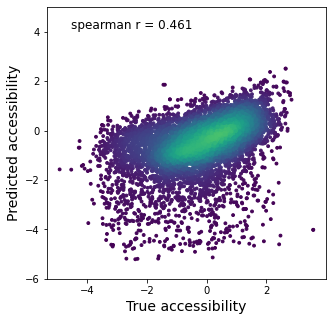

In [3]:
# Overall Spearman plot:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, spearmanr
plt.rcParams['figure.figsize'] = 5, 5

x, y = y_test, y_pred
cor = spearmanr(x,y).correlation

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=8, vmax = 0.2)
plt.ylim(-6,5)
plt.ylabel('Predicted accessibility', fontsize = 14)
plt.xlabel('True accessibility', fontsize = 14)
plt.text(-2.5, 4, 'spearman r = {:.3f}'.format(cor), 
         ha='center', va='bottom',fontsize=12)
plt.show()

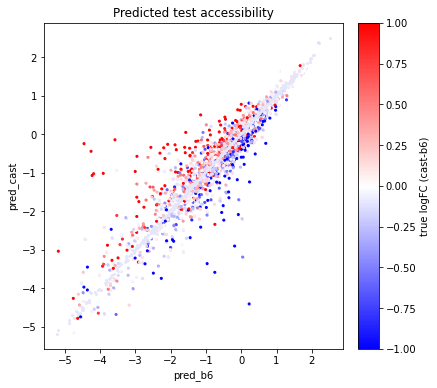

In [4]:
# Allele Specific predictions plot:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="7%", pad=0.2,)

idx = np.where(np.abs(pred_fc)>0.1)[0]
ax.scatter(y_pred[:len(y_pred)//2], y_pred[len(y_pred)//2:],
            vmax = 1, vmin = -1, cmap = 'bwr',s = 4,
           c = 'lavender')
a = ax.scatter(y_pred[:len(y_pred)//2][idx], y_pred[len(y_pred)//2:][idx],
            vmax = 1, vmin = -1, cmap = 'bwr',s = 4,
           c = true_fc[idx])
cbar = plt.colorbar(a, cax=cax)
cbar.set_label('true logFC (cast-b6)')
ax.set_title('Predicted test accessibility')
ax.set_xlabel('pred_b6')
ax.set_ylabel('pred_cast')
plt.show()

KstestResult(statistic=0.6438356164383562, pvalue=1.4813395002146913e-14)


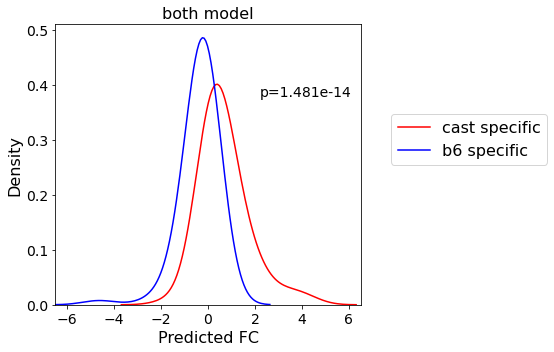

In [5]:
# KDE plot:
import seaborn as sns
from scipy.stats import ks_2samp

plt.rcParams['figure.figsize'] = 8, 5

# perform KS test on the peaks with foldchange in the top and bottom 2 percntile 
# pred_fc is the predicted foldchange and pred_fc_r is the predicted foldchange of the reverse complement
ks = ks_2samp(pred_fc[(true_fc)>np.percentile(true_fc, 98)],
              pred_fc[(true_fc)<np.percentile(true_fc, 2)])
print(ks)
sns.kdeplot(pred_fc[true_fc > np.percentile(true_fc, 98)], 
            color = 'red', bw = 0.7,legend = True,label="cast specific", linestyle="-")
sns.kdeplot(pred_fc[true_fc < np.percentile(true_fc, 2)], 
            color = 'blue', bw = 0.7,legend = True,label="b6 specific", linestyle="-")
plt.xlim(-6.5,6.5)
plt.xlabel('Predicted FC', fontsize = 16)
plt.ylabel('Density', fontsize = 16)
plt.title(dataset+' model', fontsize = 16)
plt.legend(fontsize = 16, loc = [1.1,0.5])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.text(2.2,0.38,'p={0:.3e}'.format(ks.pvalue), fontsize = 14)
plt.tight_layout()

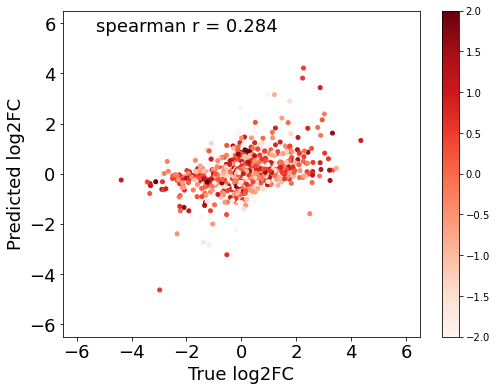

In [6]:
# Red spearman plot for fc
plt.rcParams['figure.figsize'] = 8, 6
fc_cutoff = 0. # Cutoff for peak foldchange. Points with lower absolute fold-change are greyed out

cor2 = spearmanr(true_fc[abs(true_fc)>fc_cutoff],pred_fc[abs(true_fc)>fc_cutoff]).correlation

plt.scatter(true_fc,pred_fc,vmax = 2, vmin = -2, s = 8, c = 'lavender')
plt.scatter(
           true_fc[abs(true_fc)>fc_cutoff],pred_fc[abs(true_fc)>fc_cutoff],
            vmax = 2, vmin = -2, cmap = 'Reds',s = 16, 
    c = np.max(np.array([y_test[:len(y_test)//2],
                y_test[len(y_test)//2:]]), axis = 0
      )[abs(true_fc)>fc_cutoff]
)
plt.ylabel('Predicted log2FC', fontsize = 18)
plt.xlabel('True log2FC', fontsize = 18)
plt.text(-2, 5.5, 'spearman r = {:.3f}'.format(cor2), 
         ha='center', va='bottom',fontsize=18)
plt.colorbar()
plt.xlim(-6.5,6.5)
plt.ylim(-6.5,6.5)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

# Feature Attribution

In [24]:
def unhot(x):
    # input shape (n,len,4)
    # output shape (n,len)
    x_dna = np.full((x.shape[0],x.shape[1]), 'N')
    nucs = ['A','C','G','T']
    for i in range(len(x)):
        for j in range(len(nucs)):
            idx = np.where(x_test[i,:,j])[0]
            x_dna[i][idx] = nucs[j]
    x_dna = np.array([''.join(x_dna[i]) for i in range(len(x_dna))])
    return x_dna

In [28]:
import torch
from run import alleleScan, load_data
from captum.attr import IntegratedGradients, DeepLift
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

dataset = 'both'
model = alleleScan(2, 0.2)
model.to(DEVICE)
SAVEPATH = f'{basedir}mouseASA/ckpt_models/{ctype}/{ctype}_{modelname}_{dataset}_{use_prior}_{batchsize}{gc}{ident}.hdf5'
print(SAVEPATH)
model.load_state_dict(torch.load(SAVEPATH))
model.eval()

# ig = IntegratedGradients(model)
dl = DeepLift(model)

_, x_test, _, _, y_test, _ = load_data(ctype, dataset, gc+ident)
x_test = x_test[:len(x_test)//2]                     # remove revcomps
y_test = y_test[:len(y_test)//2]
x_test_dna = unhot(x_test)

# x_test: one-hot encoded 300bp sequence inputs with shape (n, 300, 4)
attr = dict()
for k in ['dl']:
    attr[k] = []

for i in tqdm( range(0, len(x_test), int(batchsize)) ):
    test_input_tensor = torch.from_numpy(x_test[i:i+int(batchsize)]).type(torch.FloatTensor).transpose(1,2).to(DEVICE)
    test_input_tensor.requires_grad_()
#     attr['ig'].append(ig.attribute(test_input_tensor).detach().cpu().numpy())
    attr['dl'].append(dl.attribute(test_input_tensor).detach().cpu().numpy())
    
for k in attr.keys():
    attr[k] = np.concatenate(attr[k])

/data/leslie/sinhaa2/mouseASA/ckpt_models/cd8/cd8_m3_both_1_32_vi.hdf5


  0%|          | 0/228 [00:00<?, ?it/s]

In [29]:
if ident=='_vi':
    summits = pd.read_csv(aligndir+'cd8_old/yi_cd8_peaks_34075.csv',sep=',',index_col=0)
    summits['start'] += 150
    summits = summits.iloc[:,1:3]
    summits.columns = range(2)
else:
    summits = pd.read_csv(f'{basedir}mouseASA/data/{ctype}/summits{ident}.csv', header=None)
print(len(summits))

chromsummits = []
for i in chrom_test:
    chromsummits.append(np.array(summits.loc[np.where(summits[0]==i)[0],1]))
chromsummits = np.concatenate(chromsummits)

34075


In [30]:
# Get sorted fc for ranking of differentially accessible peaks
temp = np.sort( np.abs(true_fc) )[::-1]

chr10: 59380210-59380510
SNP/Indel location: [27, 63, 66, 70, 94, 95, 176, 177, 224, 228, 270, 271, 283, 284, 291, 292]
Log2fc: -4.375951009718763
b6       DeepLIFT


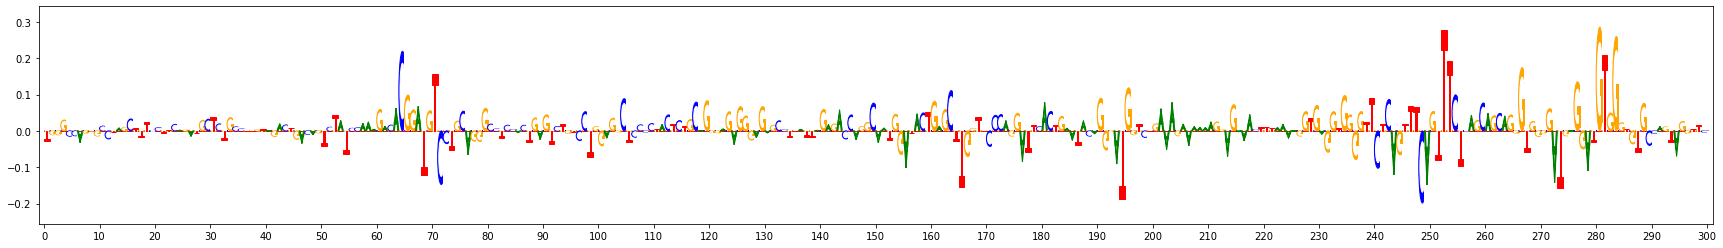

cast     DeepLIFT


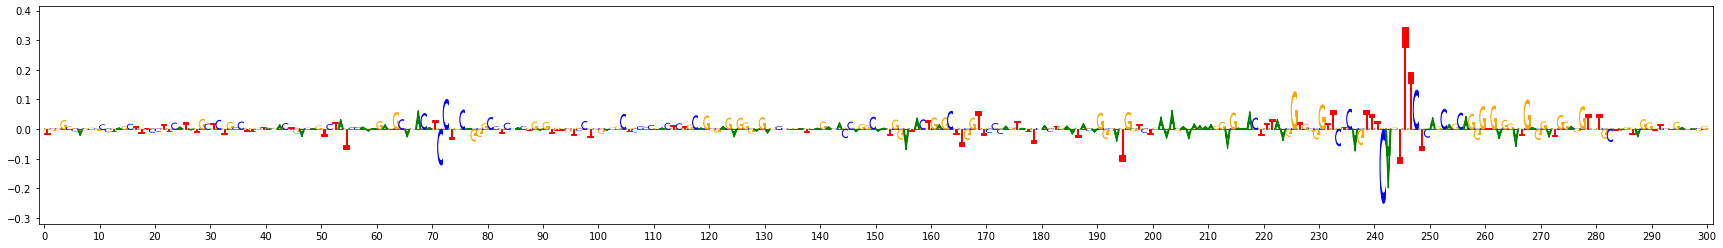

ref_b6   DeepLIFT


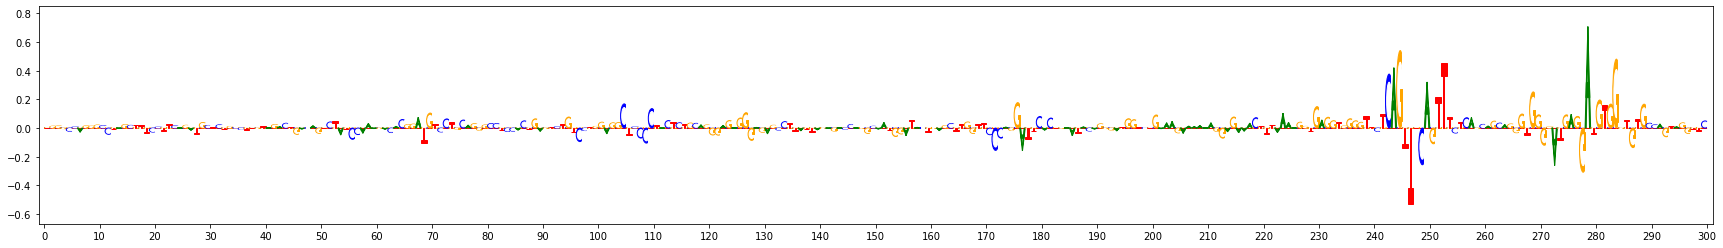

ref_cast  DeepLIFT


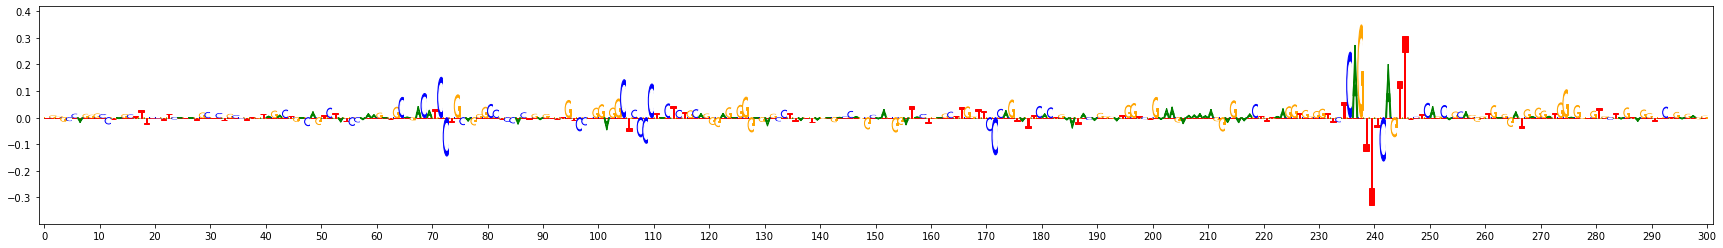

In [40]:
from Bio.Seq import Seq
from Bio import pairwise2
import deeplift
from deeplift.visualization import viz_sequence

rank = 1       # fold change rank of true accessibility change
i = np.where(np.abs(true_fc)==temp[rank-1])[0][0]
if i>=len( np.array(summits.loc[np.where(summits[0]==chrom_test[0])[0],1]) ):
    c = chrom_test[1]
else:
    c = chrom_test[0]

seq_b6 = x_test_dna[i]
seq_ca = x_test_dna[len(x_test)//2+i]

temp1 = pairwise2.format_alignment(*pairwise2.align.localxx(Seq(seq_b6), Seq(seq_ca) )[0]).split('\n')
# get locations of SNPs and indels
idx = []
cnt = 0
for j in range(1,len(temp1[0])):
    if temp1[1][j]==' ':
        if temp1[0][j]=='-':
            cnt+=1
        if temp1[1][j-1]!=' ':
            idx.append(j-cnt)

print(f'chr{c}: {chromsummits[i]-150}-{chromsummits[i]+150}')
print('SNP/Indel location:', idx)
print('Log2fc:', true_fc[i])

for k in attr.keys():
    if k=='ig':
        method_name = 'Integrated Gradient'
    elif k=='dl':
        method_name = 'DeepLIFT'
    
    scores_b6 = x_test[i]*attr[k][i].T
    scores_ca = x_test[i+len(x_test)//2]*attr[k][i+len(x_test)//2].T
    print('b6      ', method_name)
    viz_sequence.plot_weights(scores_b6, subticks_frequency=10, figsize = (30,4))
    print('cast    ', method_name)
    viz_sequence.plot_weights(scores_ca, subticks_frequency=10, figsize = (30,4))
    scores_ref = x_test[i]*attr_ref[k][i].T
    print('ref_b6  ', method_name)
    viz_sequence.plot_weights(scores_ref, subticks_frequency=10, figsize = (30,4))
    scores_ref = x_test[i+len(x_test)//2]*attr_ref[k][i+len(x_test)//2].T
    print('ref_cast ', method_name)
    viz_sequence.plot_weights(scores_ref, subticks_frequency=10, figsize = (30,4))

In [32]:
print('True fc: {:.3f}'.format(true_fc[i]) )
print('Pred fc: {:.3f}'.format(pred_fc[i]) )
print('b6 true acc: {:.3f}'.format(y_test[i]) )
print('b6 pred acc: {:.3f}'.format(y_pred[i]) )
print('cast true acc: {:.3f}'.format(y_test[i+len(y_test)//2]) )
print('cast pred acc: {:.3f}'.format(y_pred[i+len(y_pred)//2]) )

True fc: -4.376
Pred fc: -0.252
b6 true acc: 1.026
b6 pred acc: -2.659
cast true acc: -3.350
cast pred acc: -2.911
